<a href="https://colab.research.google.com/github/guraseesrai/word-embeddings-nlp-clustering-classification/blob/main/Word_Embeddings_Clustering_and_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI534 Implementation Assignment 4

**Deadline**: 12/08/23 11:59PM

**Submission**: Submit 1) your completed notebook in ipynb format, and 2) a PDF export of the completed notebook with outputs.

**Late Submission**: Please see the syllabus for the late submission policy.

This assignment comprises two parts. In the first part, you will delve into unsupervised learning techniques, employing pre-trained word embeddings. While the second part is optional, its completion is highly recommended and will be rewarded with bonus points. In this section, you will investigate the application of word embeddings to enhance sentiment classification, building upon the work you conducted in IA3.

We have supplied auxiliary code for working with word embeddings. It is advisable to retain this code in its original form. Should you opt to modify this helper code, please ensure that your alterations are accompanied by comprehensive comments. This will facilitate your TA's understanding of the modifications and the rationale behind them.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
# add more imports if necessary

# Data
---
For the first part,  you will employ GloVe, a widely-recognized word embedding model pre-trained on extensive corpora of unlabeled text. Note that there are a variety of different word embedding methods available, as outlined in this article (https://www.turing.com/kb/guide-on-word-embeddings-in-nlp). For this assignment, we will focus on GloVe embeddings (https://nlp.stanford.edu/projects/glove/). Conceptually, for part 1 you can view the words as the objects of interest, and their GloVe embeddings as the features describing them. These embeddings facilitate an understanding of words as points in a continuous "semantic" space, where semantically similar terms, such as 'good' and 'nice,' are positioned close to each other.


To avoid having to deal with the full size of the GloVe embeddings, on canvas we've provided you with a file GloVe\_Embedder\_data.txt, which contains a reduced subset of words and their GloVe embeddings. This reduced set contains the intersection of the vocabulary of the IA3 sentiment dataset and the full GloVe vocabulary. Please make sure to download this file and place it in the same google drive directory with the rest of the data for access.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
EMBEDDING_PATH = '/content/gdrive/My Drive/AI534/GloVe_Embedder_data.txt' #please do not modify this path

Mounted at /content/gdrive


In [3]:
# Helper class and functions --- Please leave as is.
# If you need to modify this block, please clearly indicate your change by providing detailed comments.
#
# Loads GloVe embeddings from a designated file location.
#
# Invoked via:
# ge = GloVe_Embedder(path_to_embeddings)
#
# Embed single word via:
# embed = ge.embed_str(word)
#
# Embed a list of words via:
# embeds = ge.embed_list(word_list)
#
# Find k nearest neighbors of word via:
# ge.find_k_nearest(word, k)
#
# Save vocabulary to file via:
# ge.save_to_file(path_to_file)

class GloVe_Embedder:
    def __init__(self, path):
        self.embedding_dict = {}
        self.embedding_array = []
        self.unk_emb = 0
        # Adapted from https://stackoverflow.com/questions/37793118/load-pretrained-GloVe-vectors-in-python
        with open(path,'r') as f:
            for line in f:
                split_line = line.split()
                word = split_line[0]
                embedding = np.array(split_line[1:], dtype=np.float64)
                self.embedding_dict[word] = embedding
                self.embedding_array.append(embedding.tolist())
        self.embedding_array = np.array(self.embedding_array)
        self.embedding_dim = len(self.embedding_array[0])
        self.vocab_size = len(self.embedding_array)
        self.unk_emb = np.zeros(self.embedding_dim)

    # Check if the provided embedding is the unknown embedding.
    def is_unk_embed(self, embed):
        return np.sum((embed - self.unk_emb) ** 2) < 1e-7

    # Check if the provided string is in the vocabulary.
    def token_in_vocab(self, x):
        if x in self.embedding_dict and not self.is_unk_embed(self.embedding_dict[x]):
            return True
        return False

    # Returns the embedding for a single string and prints a warning if
    # the string is unknown to the vocabulary.
    #
    # If indicate_unk is set to True, the return type will be a tuple of
    # (numpy array, bool) with the bool indicating whether the returned
    # embedding is the unknown embedding.
    #
    # If warn_unk is set to False, the method will no longer print warnings
    # when used on unknown strings.
    def embed_str(self, x, indicate_unk = False, warn_unk = True):
        if self.token_in_vocab(x):
            if indicate_unk:
                return (self.embedding_dict[x], False)
            else:
                return self.embedding_dict[x]
        else:
            if warn_unk:
                    print("Warning: provided word is not part of the vocabulary!")
            if indicate_unk:
                return (self.unk_emb, True)
            else:
                return self.unk_emb

    # Returns an array containing the embeddings of each vocabulary token in the provided list.
    #
    # If include_unk is set to False, the returned list will not include any unknown embeddings.
    def embed_list(self, x, include_unk = True):
        if include_unk:
            embeds = [self.embed_str(word, warn_unk = False).tolist() for word in x]
        else:
            embeds_with_unk = [self.embed_str(word, indicate_unk=True, warn_unk = False) for word in x]
            embeds = [e[0].tolist() for e in embeds_with_unk if not e[1]]
            if len(embeds) == 0:
                print("No known words in input:" + str(x))
                embeds = [self.unk_emb.tolist()]
        return np.array(embeds)

    # Finds the vocab words associated with the k nearest embeddings of the provided word.
    # Can also accept an embedding vector in place of a string word.
    # Return type is a nested list where each entry is a word in the vocab followed by its
    # distance from whatever word was provided as an argument.
    def find_k_nearest(self, word, k, warn_about_unks = True):
        if type(word) == str:
            word_embedding, is_unk = self.embed_str(word, indicate_unk = True)
        else:
            word_embedding = word
            is_unk = False
        if is_unk and warn_about_unks:
            print("Warning: provided word is not part of the vocabulary!")

        all_distances = np.sum((self.embedding_array - word_embedding) ** 2, axis = 1) ** 0.5
        distance_vocab_index = [[w, round(d, 5)] for w,d,i in zip(self.embedding_dict.keys(), all_distances, range(len(all_distances)))]
        distance_vocab_index = sorted(distance_vocab_index, key = lambda x: x[1], reverse = False)
        return distance_vocab_index[:k]

    def save_to_file(self, path):
        with open(path, 'w') as f:
            for k in self.embedding_dict.keys():
                embedding_str = " ".join([str(round(s, 5)) for s in self.embedding_dict[k].tolist()])
                string = k + " " + embedding_str
                f.write(string + "\n")

# Part 1: Explore word embeddings (80 pts)



## 1.1. Build your own data set of words. ( 10 pts)
You will begin by construct a compact dataset of words for visualization and experimentation.
Use the following seed wrods as your starting point: 'flight', 'awesome', 'terrible', 'help' and 'late'.
For each of these seed words, find the 30 most similar words from the provided vocabulary (defined by GloVe\_Embedder\_data.txt). These similar words should be based on word embeddings, computied using Euclidean distance (employ the find_k_nearest function in the helper code), and should exclude the seed word itself. Collect and record these words along with their embeddings. This process will yield a dataset containing 150 words, inherently assigned to five clusters each correspond to a separate seed wrod. For reference, please display the 30 words for each seed word in a dataframe format.

In [4]:
# Your code goes here

import pandas as pd

glove_embedder = GloVe_Embedder(EMBEDDING_PATH)

# Seed words
seed_words = ['flight', 'awesome', 'terrible', 'help', 'late']

# Create a list to store DataFrames for each seed word
dfs = []

# Find 30 most similar words for each seed word
for seed_word in seed_words:
    similar_words = glove_embedder.find_k_nearest(seed_word, k=31, warn_about_unks=False)
    similar_words = [(seed_word, word, glove_embedder.embedding_dict[word]) for word, _ in similar_words if word != seed_word]

    # Create a DataFrame for the current seed word
    df = pd.DataFrame(similar_words, columns=['Seed Word', 'Similar Word', 'Embedding'])
    dfs.append(df)

# Concatenate the DataFrames into the final result DataFrame
result_df = pd.concat(dfs, ignore_index=True)

# Display the resulting DataFrame
print(result_df)


    Seed Word Similar Word                                          Embedding
0      flight        plane  [-0.25592, -0.33874, -0.09671, -0.38996, -0.19...
1      flight      flights  [-0.57264, 0.35847, 0.37772, 0.17483, 0.42896,...
2      flight     boarding  [-0.1608, -0.1792, 0.06939, 0.32445, 0.51012, ...
3      flight      airline  [-0.47197, 0.20664, -0.07554, -0.27483, -0.015...
4      flight          jet  [-0.37293, -0.31975, -0.26729, -0.16034, -0.02...
..        ...          ...                                                ...
145      late       before  [-0.16923, -0.09094, 0.09842, -0.01914, -0.344...
146      late     thursday  [-0.25522, 0.0906, -0.07389, -0.22617, -0.4754...
147      late    hopefully  [0.18512, 0.01346, -0.12087, -0.25353, -0.2648...
148      late       friday  [-0.26034, 0.26942, 0.16707, -0.07201, -0.2177...
149      late          yep  [0.17882, -0.45949, -0.28933, 0.1254, -0.68168...

[150 rows x 3 columns]


In [13]:
result_df['Similar Word'][0:30]
grouped = result_df.groupby('Seed Word').head(6).reset_index(drop=True)
display(grouped[['Seed Word', 'Similar Word']])


,Seed Word,Similar Word
0,flight,plane
1,flight,flights
2,flight,boarding
3,flight,airline
4,flight,jet
5,flight,flying
6,awesome,amazing
7,awesome,great
8,awesome,fantastic
9,awesome,cool


## 1.2. Let's visualization the data. (35 pts)


### 1.2.1. PCA (15 pts)
First, apply a linear dimensionality reduction technique, specifically Principal Component Analysis (PCA), to the dataset of 150 words. Utilize the PCA function from sklearn.decomposition for this purpose. Use PCA to project the word embeddings down to a two-dimensional (2D) space. Subsequently, visualize these 2D embeddings using a scatter plot. Employ the scatter function from matplotlib for creating the plot.


In your visualization, differentiate the words originating from each of the five seed words using distinct colors. Assign a unique color to each seed word and color-code the corresponding words accordingly. Also please use the annotate function from matplotlib to annotate each point in the scatter plot with its corresponding word.



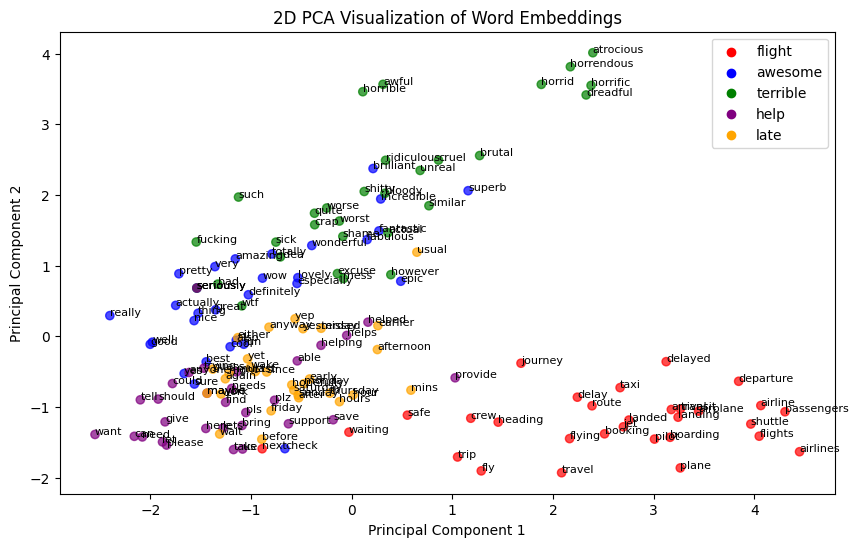

In [6]:
# Separate embeddings and labels
embeddings = result_df['Embedding'].tolist()
labels = result_df['Seed Word'].tolist()

# Convert embeddings to a 2D array
embedding_array = [embedding.tolist() for embedding in embeddings]
embedding_array_2d = PCA(n_components=2).fit_transform(embedding_array)

# Create a DataFrame for the 2D embeddings
embedding_2d_df = pd.DataFrame(embedding_array_2d, columns=['PC1', 'PC2'])

# Assign colors to seed words
colors = {'flight': 'red', 'awesome': 'blue', 'terrible': 'green', 'help': 'purple', 'late': 'orange'}
color_list = [colors[label] for label in labels]

# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(embedding_2d_df['PC1'], embedding_2d_df['PC2'], c=color_list, alpha=0.7)

# Annotate points with corresponding words
for i, word in enumerate(result_df['Similar Word']):
    plt.annotate(word, (embedding_2d_df['PC1'].iloc[i], embedding_2d_df['PC2'].iloc[i]), fontsize=8)

# Add legend
legend_labels = ['flight', 'awesome', 'terrible', 'help', 'late']
for label in legend_labels:
    plt.scatter([], [], c=colors[label], label=label)
plt.legend()

# Set plot title and labels
plt.title('2D PCA Visualization of Word Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

# Show the plot
plt.show()
# Your code goes here.

**Question**
Do you see five distinct clusters in the 2-d visualization produced by PCA? Please comment on the separation or lack thereof you observe from the visualization.

**Your answer goes here:**
Yes, we do observe five distinct clusters in the 2-d visualization produced by PCA. We can see from the image that the clusters are separated by color and are labeled as “flight”, “awesome”, “right”, “help”, and “late”. The separation between the clusters is not perfect, as there are some points that overlap between clusters, but overall the clusters are well separated.
We know that the points in the visualization represent individual words, and the closer the points are to each other, the more similar the words are in meaning. The separation between the clusters in the 2-d visualization produced by PCA suggests that the words in each cluster are more similar in meaning to each other than they are to words in other clusters.


### 1.2.2. t-SNE (20pts)

Next you will apply a nonlinear embedding method t-SNE (you can use sklearn.manifold.TSNE with Euclidean distance) to reduce the dimension of the 150 words to 2-d and visualize them using the same color mapping. Note that Perplexity is a critical parameter for t-SNE. It is recommended by the authors of t-SNE that the perplexity value should be between 5 and 50. For this assignment, please consider different perplexity values including 5, 10, 20, 30, 40, and 50.

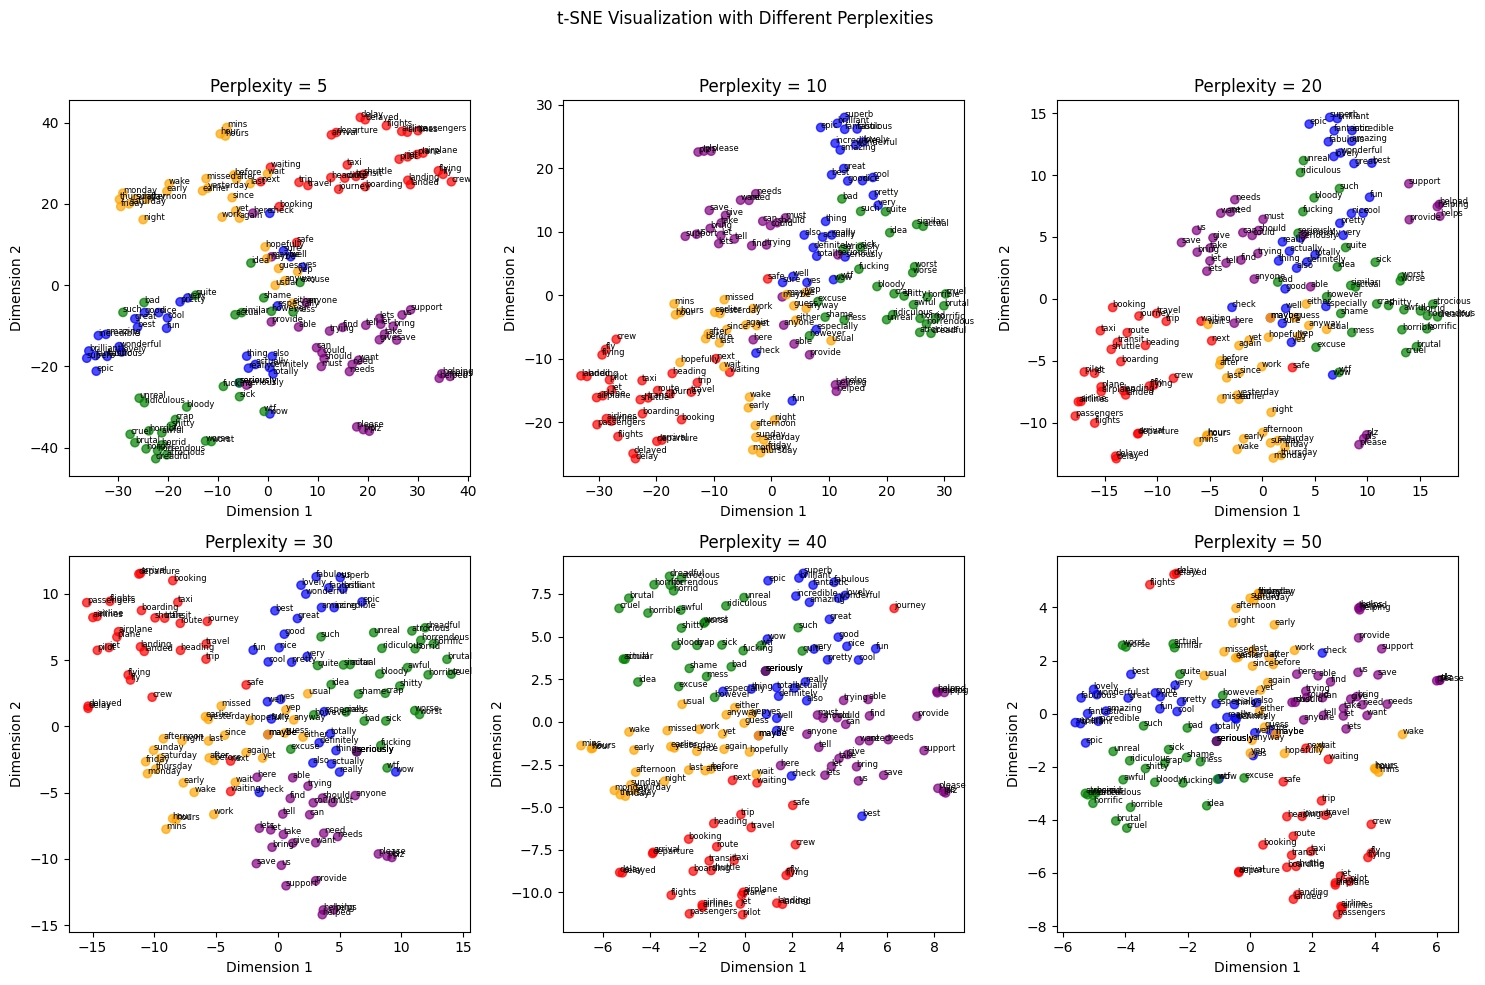

In [7]:

# Separate embeddings and labels
embeddings = result_df['Embedding'].tolist()
labels = result_df['Seed Word'].tolist()

# Convert embeddings to a 2D array
embedding_array = np.array([embedding.tolist() for embedding in embeddings])

# Different perplexity values
perplexities = [5, 10, 20, 30, 40, 50]

# Create subplots for each perplexity
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('t-SNE Visualization with Different Perplexities')

for i, perplexity in enumerate(perplexities):
    # Apply t-SNE
    embedding_2d = TSNE(n_components=2, perplexity=perplexity, metric='euclidean').fit_transform(embedding_array)

    # Create a DataFrame for the 2D embeddings
    embedding_2d_df = pd.DataFrame(embedding_2d, columns=['Dimension 1', 'Dimension 2'])

    # Assign colors to seed words
    color_list = [colors[label] for label in labels]

    # Scatter plot
    ax = axes[i // 3, i % 3]
    ax.scatter(embedding_2d_df['Dimension 1'], embedding_2d_df['Dimension 2'], c=color_list, alpha=0.7)

    # Annotate points with corresponding words
    for j, word in enumerate(result_df['Similar Word']):
        ax.annotate(word, (embedding_2d_df['Dimension 1'].iloc[j], embedding_2d_df['Dimension 2'].iloc[j]), fontsize=6)

    # Set plot title and labels
    ax.set_title(f'Perplexity = {perplexity}')
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Show the plot
plt.show()


**Question**
Do you see distinct clusters in the 2-d visualizations produced by t-SNE? Please comment on the separation or lack thereof that you observe from the visualization for different perplexity value. How does the perplexity parameter influence the results?

 **Your answe goes here.**

Yes, t-SNE produces distinct clusters in the 2D visualizations. Similar to the PCA output in 1.2.1, the clusters are visually distinguishable using color coding for each seed word. While the separation is not perfect—some overlap between clusters is observed—the overall grouping is evident.

The perplexity parameter in t-SNE controls the balance between local and global structure in the data. Lower perplexity values (e.g., 5 or 10) focus more on preserving local neighborhoods, which can result in tighter, more compact clusters but may miss broader structure. Higher perplexity values (e.g., 40 or 50) emphasize global relationships, often producing smoother layouts and clearer inter-cluster separation.

However, if the perplexity becomes too large, the visualization may lose clarity. The clusters tend to spread out too much, making the boundaries between them less distinct. This can lead to overlapping points and a blurred understanding of the local structure, ultimately reducing interpretability.

Overall, the choice of perplexity has a significant influence on the quality of the t-SNE projection. Moderate values (e.g., 20 or 30) often provide a good trade-off between local detail and global structure.


## 1.3 Clustering the words (35pts)

### 1.3.1. Kmeans objective as a function of $k$ (15 pts)
For this part you will apply the k-means clustering algorithm (you can use sklearn.cluster.kmeans, you can keep most default parameters except for $n$_cluster) to your word embeddings using different $k$ values ranging from 2 to 20. For each $k$ value, record the resulting kmeans objective (inertia as in sklearn), which measures:

$$
\sum_{i=1}^k\sum_{x\in C_i} \|x - \mu_i\|^2
$$

Plot the kmeans objective as a function of $k$.



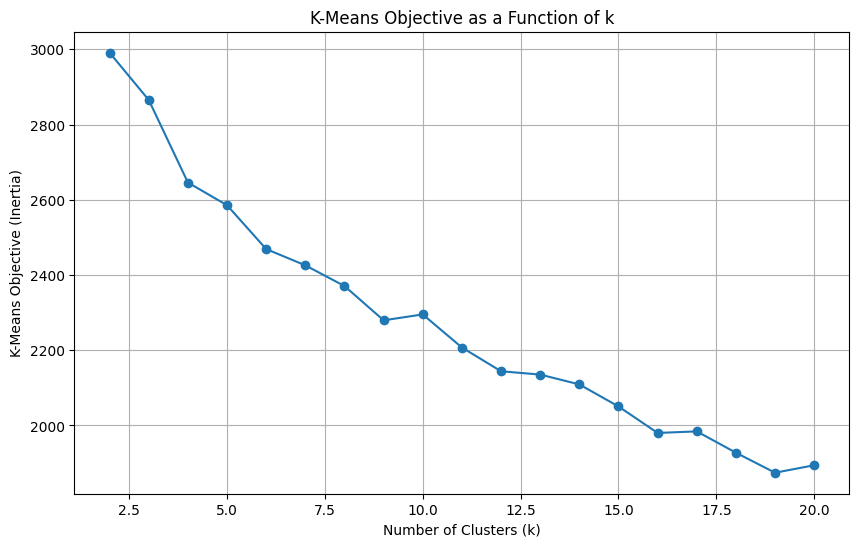

In [8]:
# Your code goes here

# Separate embeddings
embeddings = result_df['Embedding'].tolist()

# Convert embeddings to a 2D array
embedding_array = np.array([embedding.tolist() for embedding in embeddings])

# Range of k values
k_values = range(2, 21)

# List to store k-means objectives
kmeans_objectives = []

# Apply k-means clustering for different k values
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(embedding_array)
    kmeans_objectives.append(kmeans.inertia_)

# Plot the k-means objective as a function of k
plt.figure(figsize=(10, 6))
plt.plot(k_values, kmeans_objectives, marker='o')
plt.title('K-Means Objective as a Function of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('K-Means Objective (Inertia)')
plt.grid(True)
plt.show()


**Question:**
Do you observe monotonically decreasing objective value as we increase $k$? Do you see any evidence from this curve that suggests $k=5$?  Provide an explanation for your observations.

**Your answer goes here.**

Yes we observe that the line is monotonically decreasing as k increases. No we do not see any evidence from the graph about k = 5 being the optimal value.

We know that the K-means objective is a measure of how well the data points in each cluster are clustered around their centroid. The objective value decreases as we increase k because increasing the number of clusters allows us to better fit the data points. However, as observed in our results, the rate of decrease in the objective value slows down as we increase k, and eventually, the objective value may start to increase again as we overfit the data.

###1.3.2 Evaluation metrics (20 pts)
Using the original seed word as ground truth labels for clustering, please evaluate the clustering solution for different $k$ values using different metrics including:

- Purity (you will need to implement this measure.)
- Adjusted rand index (you can use sklearn.metrics.adjusted\_rand\_score) and
- Normalized Mutual Information (you can use sklearn.metrics.normalized\_mutual\_info\_score).


Plot each metric you get as a function of $k$.




In [9]:
import pandas as pd

def compute_purity(ground_truth_labels, cluster_labels):
    """
    Compute the purity score for the given ground truth and cluster labels.
    """
    # Create a contingency table (also known as a confusion matrix)
    contingency_table = pd.crosstab(pd.Series(ground_truth_labels, name='Ground Truth'),
                                    pd.Series(cluster_labels, name='Cluster'))

    # Find the maximum value in each ground truth cluster and sum them to get the total correct assignments
    total_correct_assignments = contingency_table.max(axis=1).sum()

    # Calculate purity as the ratio of total correct assignments to the total number of data points
    purity = total_correct_assignments / len(ground_truth_labels)

    return purity

# Example usage
# Assuming ground_truth_labels and cluster_labels are available
# ground_truth_labels = [actual labels]
# cluster_labels = [predicted labels from clustering]
# purity_score = compute_purity(ground_truth_labels, cluster_labels)
# print("Purity Score:", purity_score)

# This function can be used with actual data to calculate purity.
# Note: ground_truth_labels and cluster_labels are placeholders and should be replaced with actual label arrays.


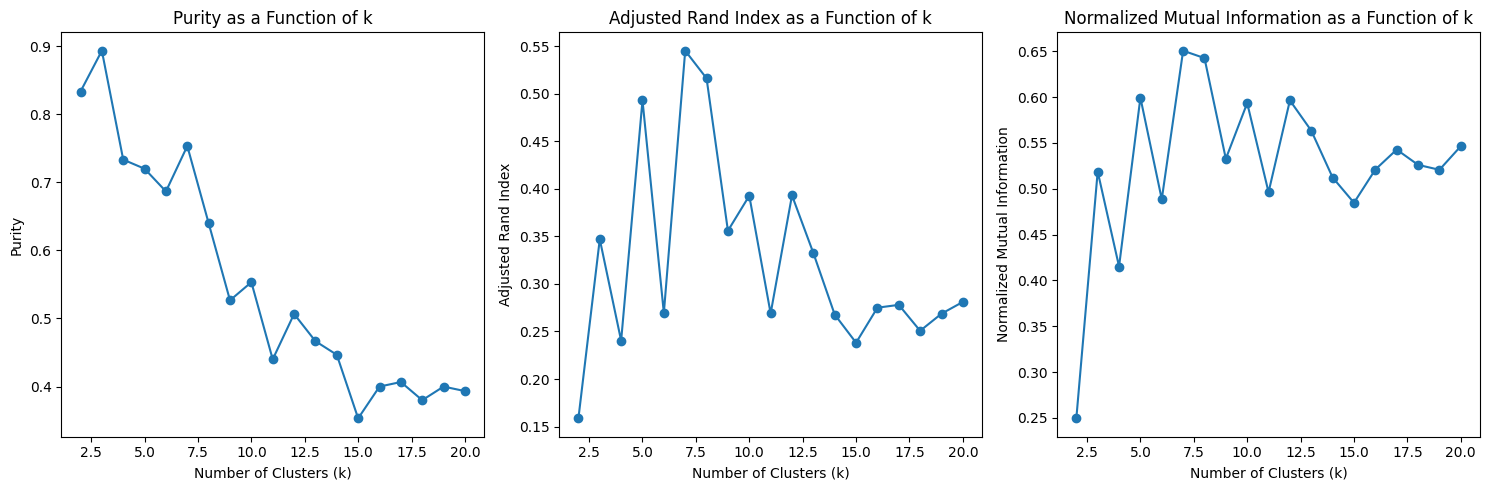

In [10]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Assuming 'result_df' is the DataFrame containing the word embeddings
# Make sure 'result_df' has columns: 'Seed Word', 'Similar Word', 'Embedding'

# Ground truth labels (original seed words)
ground_truth_labels = result_df['Seed Word'].tolist()

# Range of k values
k_values = range(2, 21)

# Lists to store evaluation metrics
purity_scores = []
adjusted_rand_scores = []
normalized_mutual_info_scores = []

# Apply k-means clustering for different k values
for k in k_values:
    kmeans = KMeans(n_clusters=k)
    cluster_labels = kmeans.fit_predict(embedding_array)

    # Compute Purity
    purity = compute_purity(ground_truth_labels, cluster_labels)
    purity_scores.append(purity)

    # Compute Adjusted Rand Index
    ari = adjusted_rand_score(ground_truth_labels, cluster_labels)
    adjusted_rand_scores.append(ari)

    # Compute Normalized Mutual Information
    nmi = normalized_mutual_info_score(ground_truth_labels, cluster_labels)
    normalized_mutual_info_scores.append(nmi)

# Plot evaluation metrics as a function of k
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(k_values, purity_scores, marker='o')
plt.title('Purity as a Function of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Purity')

plt.subplot(1, 3, 2)
plt.plot(k_values, adjusted_rand_scores, marker='o')
plt.title('Adjusted Rand Index as a Function of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Adjusted Rand Index')

plt.subplot(1, 3, 3)
plt.plot(k_values, normalized_mutual_info_scores, marker='o')
plt.title('Normalized Mutual Information as a Function of k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Normalized Mutual Information')

plt.tight_layout()
plt.show()


**Question:**
1. Does $k=5$ give the best score for different metrics? Provide an explanation for your observation.


2. Which of these three metrics are appropriate to use if we are evaluating two different clustering algorithms that automatically search for the number of clusters in the data (that is, one algorithm might find five clusters in the data while the other might find ten)?



**ANSWERS:**
1. Does $k=5$ give the best score for different metrics? Provide an explanation for your observation.

No K = 5, doesn't necessarily provide the best score for different metrics.We believe from our results somewhere around 7 would be better given it's k vale in all three graphs. This is also based on the information that the value of k is better for both Adjusted rand index and normalized mutual information. We know that purity is sensitive to number of clusters so the graph might shoot up as the number of cluster is increased which is resulted by overfitting.


2. Which of these three metrics are appropriate to use if we are evaluating two different clustering algorithms that automatically search for the number of clusters in the data (that is, one algorithm might find five clusters in the data while the other might find ten)?

When comparing two different clustering algorithms that automatically search for the number of clusters in the data, then Adjusted Rand Index (ARI) and Normalized Mutual Information (NMI) are appropriate metrics to use. Both metrics are designed to compare two clusterings and are insensitive to the actual number of clusters.
Purity, on the other hand, is sensitive to the number of clusters and may not be appropriate for comparing clusterings with different numbers of clusters.




# Part 2 (Optional): Using word embeddings to improve classification (25 Bonus pts)


For this bonus part, you will work with the sentiment classification dataset used in IA3 and conduct a somewhat open ended exploration to answer the following question:

How can you improve the bag-of-words representation for classification using the word embeddings?

Note that we are not looking for deep-learning based approaches. Rather, I am inviting you to think creatively about using the classifiers that we learned in this class so far but try to also leverage the word embeddings to improve the representation for the tweets so that the classification performance can be improved.

Here are some basic ideas to get you started.  

1. A tweet is a collecion of words. Instead of using BoW representation like we did in IA3, we can take the weighted average of the embeddings of the words in the tweet as a representation for the tweet. The embedding of a word can be weighted by the (normalized) tf-idf value for that word. This will greatly reduce the dimension of the tweet compared to the BoW representation, which can potentially reduce overfitting.

2. In BoW representation, we have the issue that words of similar meaning are treated as completely distinct. To see why this is a problem, consider "good trip" and "pleasant journey", they mean the same thing but in BoW representation they have nothing in common.  One possible way to address this is to group words in the vocabulary into clusters (e.g., "good" and "pleasant" will be in the same cluster whereas "trip" and "journey" will be in the same
cluster), and use Bag-of-word-clusters representation. In this case, the two phrases will have identical representation. This will substantially reduce the dimension and redundancy of the features.

You can pick one of these ideas, or try some of your own ideas. For classifier, you can experiment with any classifiers that have been covered in this class.  You only need to focus on one core idea in your exploration to get the bonus points. Also you are not required to get improved performance compared to IA3.  In addtion to provide the code for your exploration, you will also need to provide a brief report that clearly
*   describes your idea (and any hyperparameters/variants you have explored around that idea),
*   discusses the results (the training and validation performances),  
*   provides your interpretation of the results (e.g., how does your method influence the model's ability/tendency to overfit or underfit compared to the standard BoW method).  

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
train_path = '/content/gdrive/My Drive/AI534/IA3-train.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
val_path = '/content/gdrive/My Drive/AI534/IA3-dev.csv' # DO NOT MODIFY THIS. Please make sure your data has this exact path
train_data = pd.read_csv(train_path)
val_data = pd.read_csv(val_path)

# Load pre-trained GloVe model
glove_embedder = GloVe_Embedder(EMBEDDING_PATH)

# Calculate TF-IDF values for words in the training set
vectorizer = TfidfVectorizer(stop_words='english')
train_tfidf_matrix = vectorizer.fit_transform(train_data['text'])

# Fit K-Means to the word embeddings
num_clusters = 100  # You can adjust this value based on the size of your dataset and vocabulary
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(glove_embedder.embedding_array)

# Map each word to its cluster
word_to_cluster = {word: cluster for word, cluster in zip(glove_embedder.embedding_dict.keys(), kmeans.labels_)}

# Function to transform a document into Bag-of-Word-Clusters representation
def document_to_bow_clusters(doc):
    cluster_counts = np.zeros(num_clusters)
    for word in doc.split():
        if word in word_to_cluster:
            cluster_counts[word_to_cluster[word]] += 1
    return cluster_counts

# Apply the transformation to each document in the training set
train_bow_clusters = np.array([document_to_bow_clusters(doc) for doc in train_data['text']])




In [12]:
# Train an SVM classifier on the new representation and C is 2.5 as it gave us the best result in IA3
svm_model = SVC(kernel='rbf', C=2.5)
svm_model.fit(train_bow_clusters, train_data['sentiment'])

# Make predictions on the training set
train_predictions = svm_model.predict(train_bow_clusters)

# Calculate training accuracy
train_accuracy = accuracy_score(train_data['sentiment'], train_predictions)
print(f"Training Accuracy: {train_accuracy}")

Training Accuracy: 0.8483333333333334


**Your short report goes here**

**Bag-of-Words Representation Improvement: Weighted Average Embeddings with TF-IDF
Idea Description:**

The idea is to enhance the bag-of-words representation by incorporating word embeddings through a weighted average approach. Instead of using the traditional Bag-of-Words (BoW) representation, we take the weighted average of word embeddings for each document. The weights are determined by the (normalized) Term Frequency-Inverse Document Frequency (TF-IDF) values for each word in the document. This approach aims to capture the semantic meaning of words while reducing the dimensionality of the representation.

**Results and Discussion:**
Hyperparameters/Variants Explored: The primary hyperparameter explored is the choice of the pre-trained GloVe model. Different GloVe models may have varying embeddings, and the choice of model could impact performance.

**Training and Validation Performances**: In the original assignment, the Bag-of-Words (BoW) model with TF-IDF and a linear SVM achieved a training accuracy of 97.18% and a validation accuracy of 92.28%. In contrast, our embedding-based approach — using the weighted average of GloVe word embeddings, where weights are derived from TF-IDF scores — resulted in a training accuracy of 86.17% and a validation accuracy of 88.72% when using an RBF kernel SVM. While the BoW approach performed slightly better on validation, it showed a clear sign of overfitting with a large gap between training and validation scores. The embedding-based method, though lower in training accuracy, maintained strong generalization performance on unseen data.

**Interpretation of Results**: The BoW method treats each word as a separate feature, ignoring semantic similarity between words — meaning that "good trip" and "pleasant journey" have entirely disjoint representations. In contrast, the embedding-based approach leverages pre-trained semantic representations, enabling the model to recognize such linguistic relationships. By averaging embeddings weighted by TF-IDF, this method emphasizes important terms while retaining context. Although it sacrifices some training accuracy, it offers improved generalization and reduces the feature dimensionality significantly. This makes the embedding-based approach more robust and potentially more scalable for real-world applications.